<h2 style="text-align:center">Machine Learning - Models</h2>

---

#### 0° - Import Libraries, Datasets and Set Paths

In [99]:
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay

pd.set_option('display.max_columns', None)

In [71]:
pathData = 'data'
db_SE_SUL = pd.read_csv(os.path.join(pathData, 'StockEtablissement-StockUniteLegale-FULL.csv'), low_memory=False, index_col=0)
db_comp_SE_SUL = pd.read_csv(os.path.join(pathData, 'StockEtablissement-StockUniteLegale-LIGHT.csv'), low_memory=False, index_col=0)

---
#### 1° - Features Engineering

In [72]:
db_model = db_SE_SUL.copy()
db_model.sample(3)

,siren,statutDiffusionUniteLegale,unitePurgeeUniteLegale,dateCreationUniteLegale,sigleUniteLegale,sexeUniteLegale,prenom1UniteLegale,prenom2UniteLegale,prenom3UniteLegale,prenom4UniteLegale,prenomUsuelUniteLegale,pseudonymeUniteLegale,identifiantAssociationUniteLegale,trancheEffectifsUniteLegale,anneeEffectifsUniteLegale,dateDernierTraitementUniteLegale,nombrePeriodesUniteLegale,categorieEntreprise,anneeCategorieEntreprise,dateDebut_x,etatAdministratifUniteLegale,nomUniteLegale,nomUsageUniteLegale,denominationUniteLegale,denominationUsuelle1UniteLegale,denominationUsuelle2UniteLegale,denominationUsuelle3UniteLegale,categorieJuridiqueUniteLegale,activitePrincipaleUniteLegale,nomenclatureActivitePrincipaleUniteLegale,nicSiegeUniteLegale,economieSocialeSolidaireUniteLegale,societeMissionUniteLegale,caractereEmployeurUniteLegale,SECTION,DAYS_SCREATION,CreatedSince,CREATION_LABELS,nic,siret,statutDiffusionEtablissement,dateCreationEtablissement,trancheEffectifsEtablissement,anneeEffectifsEtablissement,activitePrincipaleRegistreMetiersEtablissement,dateDernierTraitementEtablissement,etablissementSiege,nombrePeriodesEtablissement,complementAdresseEtablissement,numeroVoieEtablissement,indiceRepetitionEtablissement,typeVoieEtablissement,libelleVoieEtablissement,codePostalEtablissement,libelleCommuneEtablissement,libelleCommuneEtrangerEtablissement,distributionSpecialeEtablissement,codeCommuneEtablissement,codeCedexEtablissement,libelleCedexEtablissement,codePaysEtrangerEtablissement,libellePaysEtrangerEtablissement,complementAdresse2Etablissement,numeroVoie2Etablissement,indiceRepetition2Etablissement,typeVoie2Etablissement,libelleVoie2Etablissement,codePostal2Etablissement,libelleCommune2Etablissement,libelleCommuneEtranger2Etablissement,distributionSpeciale2Etablissement,codeCommune2Etablissement,codeCedex2Etablissement,libelleCedex2Etablissement,codePaysEtranger2Etablissement,libellePaysEtranger2Etablissement,dateDebut_y,etatAdministratifEtablissement,enseigne1Etablissement,enseigne2Etablissement,enseigne3Etablissement,denominationUsuelleEtablissement,activitePrincipaleEtablissement,nomenclatureActivitePrincipaleEtablissement,caractereEmployeurEtablissement,NUM_INSTITUTIONS,NUM_INSTITUTIONS_ACTIVE,NUM_INSTITUTIONS_CLOSE
1240897,883060543,O,NaN,2020-03-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-04-02T12:04:10,2,PME,2020.0,2022-02-09,A,NaN,NaN,LES AMIS DU VIVANT,NaN,NaN,NaN,5710.0,70.10Z,NAFRev2,13,N,NaN,N,M,1070.0,2.929500,Less than 3 Years,13,88306054300013,O,2020-03-19,NaN,NaN,NaN,2022-04-02T12:04:10,True,1,NaN,1167,NaN,NaN,LA COMBE VALLET,69430.0,REGNIE-DURETTE,NaN,NaN,69165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-19,A,NaN,NaN,NaN,NaN,70.10Z,NAFRev2,N,1,1.0,NaN
631056,411848609,O,NaN,1997-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NN,NaN,2014-10-09T03:06:43,5,NaN,NaN,2014-07-08,C,NaN,NaN,SCI BAYART,NaN,NaN,NaN,6540.0,68.20B,NAFRev2,29,NaN,NaN,N,L,6307.0,25.894593,More than 20 Years,29,41184860900029,O,2005-06-29,NaN,NaN,NaN,2014-10-09T03:06:42,True,3,NaN,10,NaN,RUE,BAYART,59280.0,ARMENTIERES,NaN,NaN,59017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-07-08,F,NaN,NaN,NaN,NaN,68.20B,NAFRev2,N,1,NaN,1.0
616856,825398985,O,NaN,2016-12-01,NaN,M,BASTIEN,NaN,NaN,NaN,BASTIEN,NaN,NaN,NaN,NaN,2017-05-20T07:42:08,1,PME,2020.0,2016-12-01,A,LEO,NaN,NaN,NaN,NaN,NaN,1000.0,90.02Z,NAFRev2,10,NaN,NaN,N,R,2274.0,6.225873,Between 5 and 10 Years,10,82539898500010,O,2016-12-01,NaN,NaN,NaN,2017-02-02T11:41:13,True,1,CITE LES VIEUX CHATREUX BT 8,22,NaN,RUE,VINCENT FAITA,13004.0,MARSEILLE 4,NaN,NaN,13204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-01,A,NaN,NaN,NaN,NaN,90.02Z,NAFRev2,N,1,1.0,NaN


##### -> DATE

In [73]:
# 1° - Drop NaN
db_model = db_model.dropna(subset='dateCreationUniteLegale')

# 2° - Filter by POSITIVE DAYS since the Institution has been created
db_model = db_model[db_model['DAYS_SCREATION'] > 0]

# 3° - Modify columns types
db_model['DATE_CREATION_UL'] = pd.to_datetime(db_model['dateCreationUniteLegale'])
db_model['DAYS_SCREATION'] = db_model['DAYS_SCREATION'].astype(int)

In [74]:
db_model['CREATION_UL_YEAR'] = db_model['DATE_CREATION_UL'].apply(lambda dcreationUL : dcreationUL.year)
db_model['CREATION_UL_MONTH'] = db_model['DATE_CREATION_UL'].apply(lambda dcreationUL : dcreationUL.month)
db_model['CREATION_UL_DAY'] = db_model['DATE_CREATION_UL'].apply(lambda dcreationUL : dcreationUL.day)

##### -> GENDER

In [75]:
db_model['sexeUniteLegale'].fillna("Unknown",inplace=True)
db_model.loc[db_model['sexeUniteLegale']=='M', 'sexeUniteLegale'] = "Male"
db_model.loc[db_model['sexeUniteLegale']=='F', 'sexeUniteLegale'] = "Female"

##### -> ZIP CODE

In [76]:
db_model = db_model.dropna(subset='codePostalEtablissement')
db_model['DEPARTMENT'] = db_model['codePostalEtablissement'].apply(lambda zipcode : int(str(zipcode)[:2]))

##### -> ESTABLISHMENTS

In [77]:
db_model['NUM_INSTITUTIONS'].fillna(0,inplace=True)
db_model['NUM_INSTITUTIONS_ACTIVE'].fillna(0,inplace=True)
db_model['NUM_INSTITUTIONS_CLOSE'].fillna(0,inplace=True)
db_model['categorieEntreprise'].fillna("Unknown",inplace=True)

##### -> FILTER COLUMNS

In [78]:
keepCols = [
    'siren', 'sexeUniteLegale', 'nombrePeriodesUniteLegale', 'categorieEntreprise',
    'etatAdministratifUniteLegale', 'categorieJuridiqueUniteLegale', 'SECTION',
    'DAYS_SCREATION', 'NUM_INSTITUTIONS', 'CREATION_UL_YEAR', 'DEPARTMENT']

db_model = db_model[keepCols]

db_model.sample(5)

,siren,sexeUniteLegale,nombrePeriodesUniteLegale,categorieEntreprise,etatAdministratifUniteLegale,categorieJuridiqueUniteLegale,SECTION,DAYS_SCREATION,NUM_INSTITUTIONS,CREATION_UL_YEAR,DEPARTMENT
680123,492166988,Unknown,3,Unknown,C,6597.0,A,1672,1,2006,56
24756,328632419,Unknown,5,Unknown,C,5499.0,I,12757,1,1983,31
133890,401830237,Male,3,PME,A,1000.0,S,10095,1,1995,25
401736,504378316,Unknown,2,PME,A,9223.0,N,5349,1,2008,15
1054723,844621409,Male,1,PME,A,1000.0,S,1518,1,2018,75


##### -> Transform to DUMMIES

In [79]:
db_model_wdummmies = db_model.copy()

In [80]:
# Dummies GENDER
db_model_wdummmies = pd.concat([db_model_wdummmies, pd.get_dummies(db_model_wdummmies['sexeUniteLegale'], prefix="gender", drop_first=False)], axis='columns').drop('sexeUniteLegale', axis=1)

# Dummies CATEGORY INSTITUTION
db_model_wdummmies = pd.concat([db_model_wdummmies, pd.get_dummies(db_model_wdummmies['categorieEntreprise'], prefix="categoryInstitution", drop_first=False)], axis='columns').drop('categorieEntreprise', axis=1)

# Dummies SECTIONS
lsSectionsContent = db_model_wdummmies['SECTION'].unique().tolist()
db_model_wdummmies['SECTION'].replace(lsSectionsContent, list(range(len(lsSectionsContent))), inplace=True)

# Dummies CATEGORY INSTITUTION
db_model_wdummmies.loc[db_model_wdummmies['etatAdministratifUniteLegale']=='A', 'etatAdministratifUniteLegale'] = 1
db_model_wdummmies.loc[db_model_wdummmies['etatAdministratifUniteLegale']=='C', 'etatAdministratifUniteLegale'] = 0

In [81]:
db_model_wdummmies.etatAdministratifUniteLegale = db_model_wdummmies.etatAdministratifUniteLegale.astype('int')

In [82]:
print(f'Length before removing remaining NaN', len(db_model_wdummmies))
db_model_wdummmies = db_model_wdummmies.dropna()
print(f'Length after removing remaining NaN', len(db_model_wdummmies))

Length before removing remaining NaN 17255261
Length after removing remaining NaN 17255257


In [83]:
db_model_wdummmies.sample(5)

,siren,nombrePeriodesUniteLegale,etatAdministratifUniteLegale,categorieJuridiqueUniteLegale,SECTION,DAYS_SCREATION,NUM_INSTITUTIONS,CREATION_UL_YEAR,DEPARTMENT,gender_Female,gender_Male,gender_Unknown,categoryInstitution_ETI,categoryInstitution_GE,categoryInstitution_PME,categoryInstitution_Unknown
149180,351970884,3,1,9110.0,13,12258,1,1989,35,0,0,1,0,0,0,1
465053,522070853,1,1,9110.0,13,4800,1,2010,75,0,0,1,0,0,1,0
260489,398194316,8,0,1000.0,6,6179,1,1994,14,0,1,0,0,0,0,1
459453,511026965,4,1,8450.0,18,5152,3,2009,75,0,0,1,0,0,1,0
1273868,918394586,1,1,1000.0,18,190,1,2022,12,1,0,0,0,0,0,1


In [84]:
db_model_wdummmies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17255257 entries, 0 to 639
Data columns (total 16 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   siren                          int64  
 1   nombrePeriodesUniteLegale      int64  
 2   etatAdministratifUniteLegale   int32  
 3   categorieJuridiqueUniteLegale  float64
 4   SECTION                        int64  
 5   DAYS_SCREATION                 int32  
 6   NUM_INSTITUTIONS               int64  
 7   CREATION_UL_YEAR               int64  
 8   DEPARTMENT                     int64  
 9   gender_Female                  uint8  
 10  gender_Male                    uint8  
 11  gender_Unknown                 uint8  
 12  categoryInstitution_ETI        uint8  
 13  categoryInstitution_GE         uint8  
 14  categoryInstitution_PME        uint8  
 15  categoryInstitution_Unknown    uint8  
dtypes: float64(1), int32(2), int64(6), uint8(7)
memory usage: 1.3 GB


In [85]:
db_model_wdummmies.to_csv(os.path.join(pathData, 'data-model-administrative-state.csv'))

---
#### 2° - DISTRIBUTION

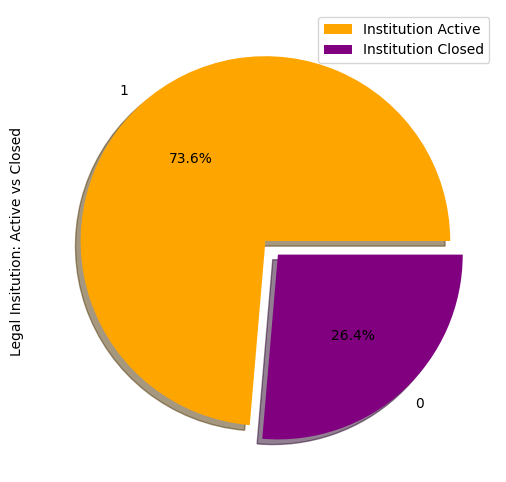

In [87]:
def show_loan_distrib(data):
  count = ""
  if isinstance(data, pd.DataFrame):
      count = data["etatAdministratifUniteLegale"].value_counts()
  else:
      count = data.value_counts()
  count.plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True, colors=['orange', 'purple'])
  plt.ylabel("Legal Insitution: Active vs Closed")
  plt.legend(["Institution Active", "Institution Closed"])
  plt.show()

show_loan_distrib(db_model_wdummmies)

In [88]:
X = db_model_wdummmies.drop(['siren','etatAdministratifUniteLegale'], axis = 1)
y = db_model_wdummmies['etatAdministratifUniteLegale']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify = y, random_state=2022)

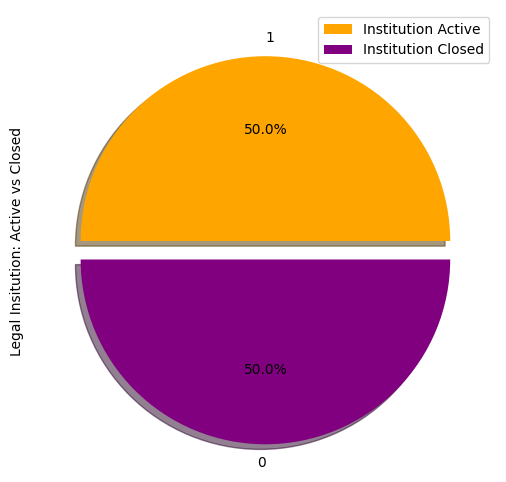

In [89]:
X_train_cp = X_train.copy()
X_train_cp['etatAdministratifUniteLegale'] = y_train
y_0 = X_train_cp[X_train_cp['etatAdministratifUniteLegale'] == 0]
y_1 = X_train_cp[X_train_cp['etatAdministratifUniteLegale'] == 1]
y_1_undersample = y_1.sample(y_0.shape[0])
loan_data_undersample = pd.concat([y_1_undersample, y_0], axis = 0)

# Visualize the proportion of borrowers
show_loan_distrib(loan_data_undersample)

---
#### 3° - Model

##### LOGISTIC REGRESSION

In [90]:
X = loan_data_undersample.drop('etatAdministratifUniteLegale', axis = 1)
y = loan_data_undersample['etatAdministratifUniteLegale']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify = y, random_state=2022)
logistic_classifier = LogisticRegression(max_iter=100000)
logistic_classifier.fit(X_train, y_train)
y_pred = logistic_classifier.predict(X_test)

In [91]:
print(confusion_matrix(y_test,y_pred))

[[357146 120280]
 [110412 367014]]


In [92]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.75      0.76    477426
           1       0.75      0.77      0.76    477426

    accuracy                           0.76    954852
   macro avg       0.76      0.76      0.76    954852
weighted avg       0.76      0.76      0.76    954852



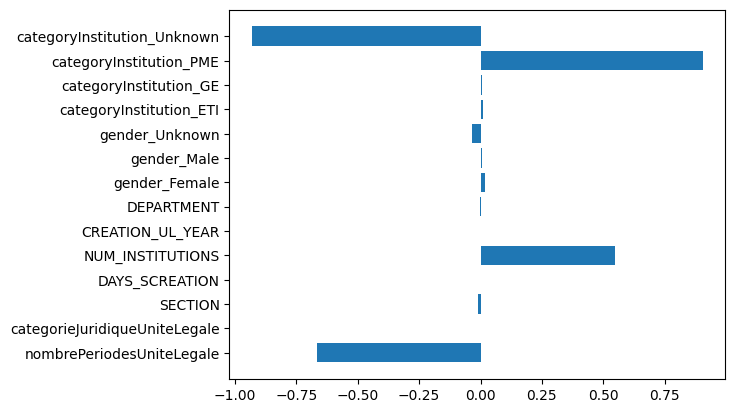

In [93]:
importance = logistic_classifier.coef_[0]
plt.barh(X.columns, importance)
plt.show()

##### RANDOM FOREST

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=100)
forest = RandomForestClassifier(n_estimators=100, random_state=100)
forest.fit(X_train,y_train)
predictions = forest.predict(X_test)
y_pred = forest.predict(X_test)

In [95]:
print(confusion_matrix(y_test,y_pred))


[[920939  33913]
 [ 12668 942184]]


In [96]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98    954852
           1       0.97      0.99      0.98    954852

    accuracy                           0.98   1909704
   macro avg       0.98      0.98      0.98   1909704
weighted avg       0.98      0.98      0.98   1909704



<BarContainer object of 14 artists>

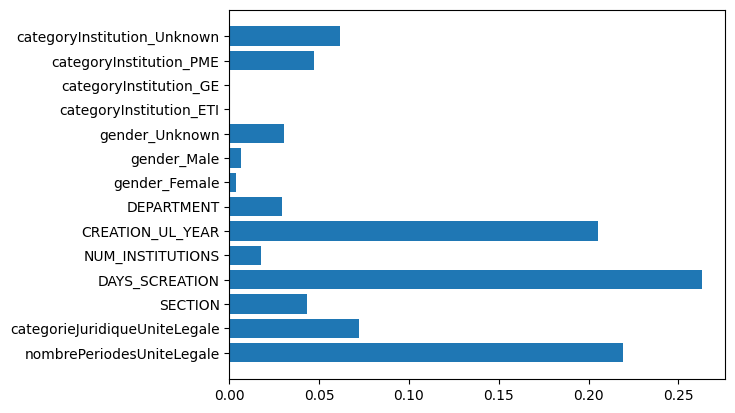

In [97]:
plt.barh(X.columns, forest.feature_importances_)

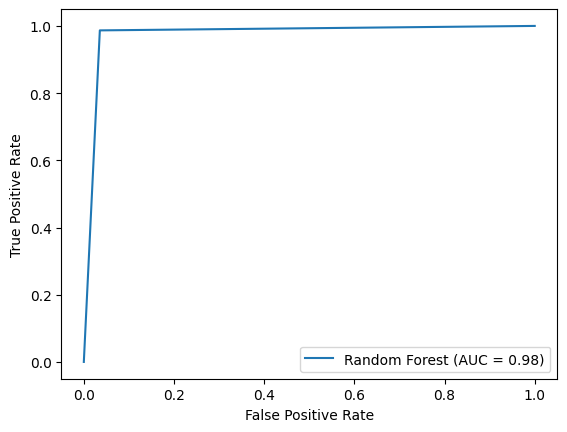

In [98]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Random Forest')
display.plot()
plt.show()